In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Required Libraries

In [ ]:
!pip install preprocess
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==1.0.0-alpha0
!pip install h5py pyyaml

Import Requiered Libraries

In [ ]:
%load_ext tensorboard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess as pp
import itertools
import cv2

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import  PIL.Image

Using tf.config.list_physical_devices('GPU') to confirm that TensorFlow is using the GPU.

Also limiting the GPU consumption

In [ ]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


Import the labeled dataset from  NASA’s LAADS DAAC
archives. 

Fast Fourier Transform has been applied to the images in the dataset for denoising.

In [ ]:
data_path = ('/content/drive/MyDrive/fft-denoised/')
os.chdir(data_path)
print(os.path.abspath(os.getcwd()))

/content/drive/MyDrive/fft-denoised


Loading the pre-trained model Inception V3, which is trained with imagenet dataset.

All layers in the Inception V3 has been assigned to not be trainable.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf

from keras import regularizers
from keras.models import Model

base_model = InceptionV3(input_shape = (256,256,3), include_top = False, weights = 'imagenet')

# Freeze all the layers
for layer in base_model.layers:
  layer.trainable = False

# Check the trainable status of the individual layers

#for layer in base_model.layers:
  #print(layer, layer.trainable)

#base_model.summary()

87910968/87910968 [==============================] - 3s 0us/step


Split the model up to the module mixed7.

Assigned 'mixed7' as the last layer from the model, thus the rest of the layers won't be used during training or evaluation.

The reason for that is because for the Inception Model V3, the largest feature map is produced by this layer, and further layers have lower dimensions. So for the purpose of feature extraction, we want to use the feature map with the most dimensions possible.

In [ ]:
last_layer = base_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


Applied regularizers to all Conv2D layers

In [ ]:
for layer in base_model.layers:
  if layer.__class__.__name__ == 'Conv2D':
    layer.kernel_regularizer = keras.regularizers.l1(0.0001)
    layer.kernel_regularizer = keras.regularizers.l2(0.0001)

Defining the custom trainable layers.


In [ ]:
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Conv2D, Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def model_call():

  x = layers.Flatten()(last_output) #mixed 7

  # Add a fully connected layer with 1,024 hidden units and ReLU activation

  x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.3)(x)      

  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)         

  model = Model(base_model.input, x)

  model.compile(optimizer = Adam(lr=1e-04),
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
  return model

In [ ]:
#model.summary()

This callback function will simply prompt, during training, your validation accuracy % 

if validation accuracy achieves over 90%, 93% it will be notified during training.
if validation accuracy is higher than 94%, it will stop training.

For training, if you achieve 100% or 95% training accuracy, it will be notified during training.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = False

    elif(logs.get('val_accuracy')>0.9499):
      print("\nReached 95% or more validation accuracy, training finished.")
      self.model.stop_training = False

    elif(logs.get('val_accuracy')>0.93):
      print(f"\nReached 93% validation accuracy mark!!!")
      
    elif(logs.get('val_accuracy')>0.8999):
      print(f"\nReached 90% validation accuracy mark!")
      
accstop = myCallback()

Defined the data generators for the train class, test class and validation class respectively.

Also applied Data Augmentation.

Class mode is set to binary since we are interested only in two types of output, true or false.


In [ ]:
batch_size = 27 #Defined batch size

train_datagen = ImageDataGenerator(
        width_shift_range = 0.2,
        rescale=1/255,
        shear_range=0.2,
        horizontal_flip=True,
        )

test_datagen = ImageDataGenerator(
        rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(256, 256),
        batch_size= batch_size,
        class_mode='binary')

train_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
  train = train_generator.next()
  train_list.append(train[0])
  batch_index = batch_index + 1

train_array = np.asarray(train_list)

validation_generator = train_datagen.flow_from_directory(
        './validation',
        target_size=(256, 256),
        batch_size= 20,
        class_mode='binary')

validation_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
  validation = validation_generator.next()
  validation_list.append(validation[0])
  batch_index = batch_index + 1

validation_array = np.asarray(validation_list)

test_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(256, 256),
        batch_size= batch_size,
        class_mode= 'binary')

test_list = []
batch_index = 0
while batch_index <= test_generator.batch_index:
  test = test_generator.next()
  test_list.append(test[0])
  batch_index = batch_index + 1 

test_array = np.asarray(test_list)

Found 348 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Found 58 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Found 236 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This loop will show how the data augmentation generated new images from the dataset

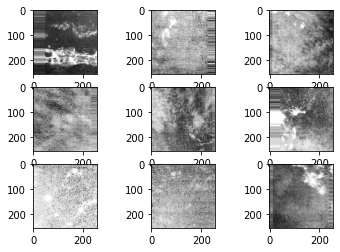

In [ ]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    images, labels = train_generator.next()
    image = (images[0]*255).astype('uint8')
    plt.imshow(image)

This function allows you to visualize the model.


In [ ]:
model1 = model_call()

plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True) 

First, we defined a callback for the Learning Rate Scheduler, where it will lower learning rate if there is no improvemnt on validation loss during training.

After that, defined empty lists to store the scores from the validation and loss of the test generator during training. 

Also, the scores from training accuracy, loss and validation accuracy, loss are stored.

And Finally, the highest validation scores and lowest loss scores are recorded.


In [ ]:
from tensorflow.keras import callbacks

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=20, min_lr= 1e-13)

test_acc_per_fold = []; test_loss_per_fold = []

model = model_call()
epoch = 300

kh = model.fit(        
        train_generator,
        steps_per_epoch= 3,
        epochs = epoch,
        validation_data=validation_generator,
        callbacks = [accstop, reduce_lr],
        validation_steps= 1
        )
   
scores = model.evaluate(train_generator, verbose=0)

results = model.evaluate(validation_generator, verbose = 0)

test_results = model.evaluate(test_generator, verbose = 0)

best_acc = max(kh.history['accuracy']); best_loss = min(kh.history['loss']); best_val_acc = max(kh.history['val_accuracy']); best_val_loss = min(kh.history['val_loss'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300
3/3 [==============================] - 9s 3s/step - loss: 1.4829 - accuracy: 0.4321 - val_loss: 0.9778 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 2/300
3/3 [==============================] - 4s 2s/step - loss: 0.7962 - accuracy: 0.4938 - val_loss: 0.6417 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 3/300
3/3 [==============================] - 4s 2s/step - loss: 0.6194 - accuracy: 0.6129 - val_loss: 0.6342 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 4/300
3/3 [==============================] - 4s 2s/step - loss: 0.6841 - accuracy: 0.5645 - val_loss: 0.5899 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 5/300
3/3 [==============================] - 4s 2s/step - loss: 0.6182 - accuracy: 0.6049 - val_loss: 0.4668 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 6/300
3/3 [==============================] - 5s 2s/step - loss: 0.6428 - accuracy: 0.6296 - val_loss: 0.5185 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 7/300
3/3 [==============================] - 5s 2s/step - loss: 

In [ ]:
print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')

print(f'Training Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%;  \n' )

print(f'Validation Score: {model.metrics_names[0]} of {results[0]}; validation {model.metrics_names[1]} of {results[1]*100}%;  \n' )

print(f'Test Score: test {model.metrics_names[0]} of {test_results[0]}; test {model.metrics_names[1]} of {test_results[1]*100}%;  \n' )

print(f' Best Accuracy: {best_acc*100}%;  Best Loss: {best_loss}; Best Val_Accuracy: {best_val_acc*100}%; Best Val_Loss: {best_val_loss} \n' )

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Training Score : loss of 0.2801409363746643; accuracy of 89.99999761581421%;  

Validation Score: loss of 0.5361030101776123; validation accuracy of 74.28571581840515%;  

Test Score: test loss of 0.5719607472419739; test accuracy of 75.8474588394165%;  

 Best Accuracy: 96.77419066429138%;  Best Loss: 0.18052047491073608; Best Val_Accuracy: 94.9999988079071%; Best Val_Loss: 0.2298315018415451 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------


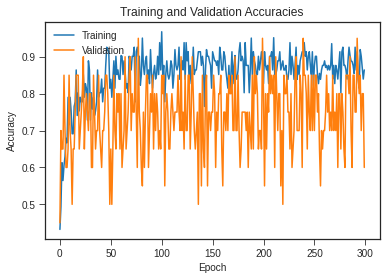

In [ ]:
plt.plot(kh.history['accuracy'])
plt.plot(kh.history['val_accuracy'])
plt.title('Training and Validation Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper left')
plt.show()

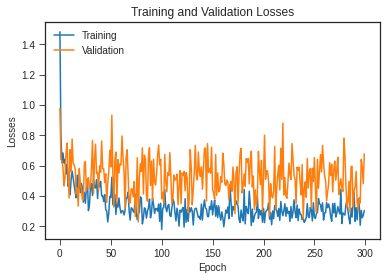

In [ ]:
plt.plot(kh.history['loss'])
plt.plot(kh.history['val_loss'])
plt.title('Training and Validation Losses')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper left')
plt.show()

Shows evaluation score of the test generator after training.

In [ ]:
_, acc = model.evaluate(test_generator)
print(acc)

9/9 [==============================] - 5s 518ms/step - loss: 0.5720 - accuracy: 0.7585
0.758474588394165


Shows evaluation score of the validation generator after training.



In [ ]:
_, acc = model.evaluate(validation_generator)
print(acc)

7/7 [==============================] - 5s 647ms/step - loss: 0.5250 - accuracy: 0.7571
0.7571428418159485


This function allows to calculare presicion, recall, accuracy and f1 scores after training, for validation generator.

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

pre = Precision()
re = Recall()

for batch in validation:
  X,y = validation
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)

f1_score = (2 * pre.result().numpy() * re.result())/(pre.result().numpy() + re.result())

print('For Validation: ')
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, F1 Score: {f1_score}')

For Validation: 
Precision: 0.6666666865348816, Recall: 0.800000011920929, Accuracy: 0.699999988079071, F1 Score: 0.7272727489471436


This function allows to calculare presicion, recall and f1 scores after training, for test generator.

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

pre = Precision()
re = Recall()

for batch in test:
  X,y = test
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)

f1_score = (2 * pre.result().numpy() * re.result())/(pre.result().numpy() + re.result())

print('For Test: ')
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, F1 Score: {f1_score}')

For Test: 
Precision: 0.6666666865348816, Recall: 1.0, Accuracy: 0.800000011920929, F1 Score: 0.800000011920929


Function to print predictions from validation and test generators


In [ ]:
pred = model.predict(validation_generator)
test_pred = model.predict(test_generator)

print("validation predictions:\n")

def countpredictions(predictions, gw = 0, ngw = 0):
  for pred in predictions:
    if pred > 0.5:
      ngw += 1
    else:
      gw += 1
  return gw, ngw

print(countpredictions(pred, 0, 0))

print("\ntest predictions:\n")

def countpredictions(predictions, gw = 0, ngw = 0):
  for test_pred in predictions:
    if test_pred > 0.5:
      ngw += 1
    else:
      gw += 1
  return gw, ngw

print(countpredictions(test_pred, 0, 0))

validation predictions:

(72, 68)

test predictions:

(112, 124)


Function to calculate and print confusion matrix



In [ ]:
import sklearn.metrics as metrics

print("Confusion Matrix: \n")
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
pred = np.round(pred)
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=pred)
confusion_matrix

#true positives, false negatives
#false positives, tru negatives

Confusion Matrix: 



array([[41, 29],
       [31, 39]])

Function to plot the learning rate changes during training.


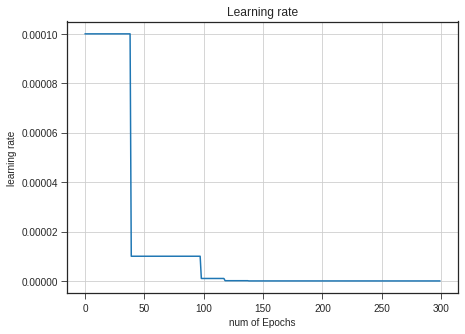

In [ ]:
nb_epoch = len(kh.history['loss'])
learning_rate=kh.history['lr']
xc=range(nb_epoch)
plt.figure(3,figsize=(7,5))
plt.plot(xc,learning_rate)
plt.xlabel('num of Epochs')
plt.ylabel('learning rate')
plt.title('Learning rate')
plt.grid(True)
plt.style.use(['seaborn-ticks'])